In [122]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from functools import partial
import jax
import jax.numpy as jnp

In [123]:
import mujoco
import mujoco_viewer
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import copy as cp

In [124]:
# Paden-Kahan

In [135]:
def quaternion_to_rotation_matrix(q):
    """
    Convert a quaternion into a rotation matrix
    :param q: Quaternion in the form [w, x, y, z]
    :return: 3x3 rotation matrix
    """
    w, x, y, z = q
    return np.array([
        [1 - 2*y**2 - 2*z**2,     2*x*y - 2*z*w,         2*x*z + 2*y*w],
        [2*x*y + 2*z*w,           1 - 2*x**2 - 2*z**2,   2*y*z - 2*x*w],
        [2*x*z - 2*y*w,           2*y*z + 2*x*w,         1 - 2*x**2 - 2*y**2]
    ])

def quad_inverse_kinematics(q_in, foot_locs_in):  
    q = np.array(q_in).reshape((7,))
    foot_locs = np.array(foot_locs_in).reshape((12,))
    foot_locs[::3] = foot_locs[::3] * -1
    # Convert quaternion to rotation matrix
    rot = quaternion_to_rotation_matrix(q[3:])
    base_pos = q[:3]

    h = 0.08  # Hip offset
    l1 = 0.213  # Thigh length
    l2 = 0.213  # Calf length

    foot_q = np.zeros((12, 2))

    hip_local_pos = np.array([[-0.1881, 0.04675, 0],
                              [-0.1881, -0.04675, 0],
                              [0.1881, 0.04675, 0],
                              [0.1881, -0.04675, 0]])
    for footInd in range(4):
        hip_trans = -hip_local_pos[footInd] - np.matmul(rot.T, base_pos)
        footPos = np.matmul(rot.T, foot_locs[3*footInd:3*footInd+3]) + hip_trans
        #print("footPos:{}".format(footPos))
        if footInd % 2 == 1:
            footPos[1] = -footPos[1]

        x, y, z = footPos
        
        #print(footPos)
        L_squared = y**2 + z**2 - h**2
        #print("L_squared:{}".format(L_squared))
        L = np.sqrt(L_squared) if L_squared > 1e-12 else 0
        #print("L:{}".format(L))
        cos_theta = (h*y - L*z) / (L**2 + h**2)
        sin_theta = (L*y + h*z) / (L**2 + h**2)
        #print(cos_theta)
        #print(sin_theta)
        foot_q[3*footInd, 0] = np.arctan2(sin_theta, cos_theta)
        #print(foot_q[:,0])
        #print("------")
        
        cos_theta = (h*y + L*z) / (L**2 + h**2)
        sin_theta = (-L*y + h*z) / (L**2 + h**2)
        foot_q[3*footInd, 1] = np.arctan2(sin_theta, cos_theta)
        for j in [0, 1]:

            z_rot = np.sin(-foot_q[3*footInd, j]) * y + np.cos(-foot_q[3*footInd, j]) * z
            arccos_argument = (l1**2 + l2**2 - (x**2 + z_rot**2)) / (2 * l1**2)
            print("Argument arcos: ", arccos_argument)
            foot_q[3*footInd + 2, j] = np.arccos(arccos_argument) - np.pi
            foot_q[3*footInd + 1, j] = -foot_q[3*footInd + 2, j] / 2 - np.arctan2(z_rot, x) - np.pi / 2

        if footInd % 2 == 1:
            foot_q[3*footInd, :] *= -1
    return np.round(foot_q[:,0], 4)

In [136]:
%pwd

'/home/juan/Documents/rexlab/mppi_project/legged_control_pub/scripts/gaits'

In [137]:
#model_sim = mujoco.MjModel.from_xml_path("../models/go1/go1_scene_jax_no_collision.xml")
model_sim = mujoco.MjModel.from_xml_path("../models/go1/go1_scene_mppi.xml")

In [138]:
dt_sim = 0.01
model_sim.opt.timestep = dt_sim

data_sim = mujoco.MjData(model_sim)

In [139]:
viewer = mujoco_viewer.MujocoViewer(model_sim, data_sim, 'offscreen')

In [130]:
np.arctan2(0, 1)

0.0

In [141]:
q_in = np.array([0.0, 0.0, 0.27, 1.0, 0.0, 0.0, 0.0]) # Base position and orientation (quaternion)
foot_locs_in = np.array([0.1881, 0.12675, 0.0,   # FL
                         0.1881, -0.12675, 0.0,  # FR
                        -0.1881, 0.12675, 0.0,   # RL
                        -0.1881, -0.12675, 0.0   # RR
                         ])
# foot_locs_in = np.array([0.1881, 0.12675, 0.00519415,   # FL
#                          0.1881, -0.12675, 0.00519415,  # FR
#                         -0.1881, 0.12675, 0.00519415,   # RL
#                         -0.1881, -0.12675, 0.00519415   # RR
#                          ])
# foot_locs_in = np.array([0.1881, 0.16, 0.00519415,   # FL
#                          0.1881, -0.16, 0.00519415,  # FR
#                         -0.1881, 0.16, 0.00519415,   # RL
#                         -0.1881, -0.16, 0.00519415   # RR
#                          ])

In [142]:
foot_locs_in

array([ 0.1881 ,  0.12675,  0.     ,  0.1881 , -0.12675,  0.     ,
       -0.1881 ,  0.12675,  0.     , -0.1881 , -0.12675,  0.     ])

In [143]:
quad_inverse_kinematics(q_in, foot_locs_in)

Argument arcos:  0.19658797857567936
Argument arcos:  0.19658797857567936
Argument arcos:  0.19658797857567936
Argument arcos:  0.19658797857567936
Argument arcos:  0.19658797857567936
Argument arcos:  0.19658797857567936
Argument arcos:  0.19658797857567936
Argument arcos:  0.19658797857567936


array([ 0.    ,  0.8843, -1.7687, -0.    ,  0.8843, -1.7687,  0.    ,
        0.8843, -1.7687, -0.    ,  0.8843, -1.7687])

In [71]:
DT = 0.01
# OVERLAP_TIME = 0.08 # duration of the phase where the foot is on the ground
# SWING_TIME = 0.05 # duration of the phase where the foot is on the ground
# SWING_HEIGHT = 0.08
OVERLAP_TIME = 0.1 # duration of the phase where the foot is on the ground
SWING_TIME = 0.05 # duration of the phase where the foot is on the ground
SWING_HEIGHT = 0.25

In [72]:
def swing_ticks():
    return int(SWING_TIME / DT)

def overlap_ticks():
    return int(OVERLAP_TIME / DT)

def stance_ticks():
    return 2 * overlap_ticks() + swing_ticks()

def phase_ticks():
    return jnp.array([overlap_ticks(),
                      swing_ticks(), 
                      overlap_ticks(),
                      swing_ticks()])

def phase_length():
    return 2 * swing_ticks() + 2 * overlap_ticks()

In [73]:
phase_length()

30

In [74]:
swing_ticks()

5

In [75]:
stance_ticks()

25

In [76]:
def get_swing_foot_z_reference():
    if swing_ticks()%2 != 0:
        knot_points = np.array([0, SWING_HEIGHT, 0])
        time_points = np.array([0, swing_ticks()/2-1, swing_ticks()-1])
    else:    
        knot_points = np.array([0, SWING_HEIGHT, SWING_HEIGHT, 0])
        time_points = np.array([0, np.floor(swing_ticks()/2-1), np.ceil(swing_ticks()/2), swing_ticks()-1])

    reference_spline = CubicSpline(time_points, knot_points, axis=1)

    x_ref = np.arange(swing_ticks())
    y_ref = reference_spline(x_ref)
    return y_ref

def get_stance_foot_z_reference():
    n = stance_ticks()
    y_ref = np.zeros(n)
    return y_ref

In [77]:
swing_ref = get_swing_foot_z_reference()

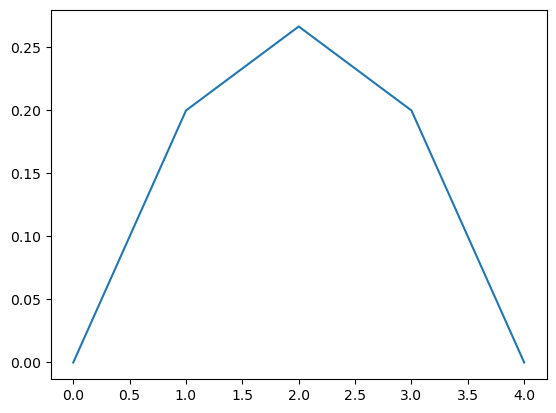

In [78]:
plt.plot(swing_ref)

In [79]:
stance_ref = get_stance_foot_z_reference()
stance_ref

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

In [80]:
gait_z_ref = np.concatenate([stance_ref, swing_ref])

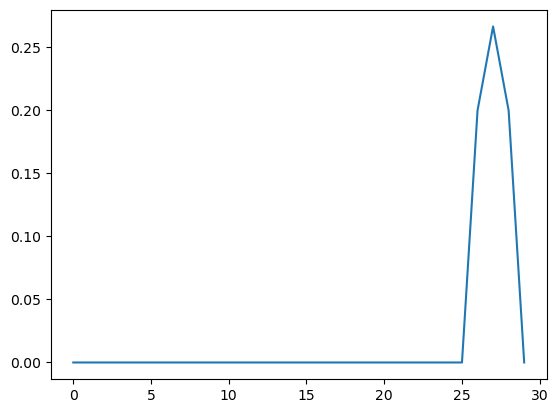

In [81]:
plt.plot(gait_z_ref)

In [82]:
foot_locs_in.shape

(12,)

In [83]:
def get_phase_variable(ticks, phase_offset):
    phase_time =  jnp.mod(ticks + phase_offset, phase_length()) 
    cycle_index = (ticks + phase_offset) // phase_length()
    
    def cond_func(carry):
        i, phase_sum, phase_relative_ticks = carry
        break_condition = (phase_time < phase_sum)
        return ~break_condition & (i < NUM_PHASES)

    def body_func(carry):
        i, phase_sum, phase_relative_ticks = carry

        phase_sum += phase_ticks()[i]
        subphase_ticks = phase_time - phase_sum + phase_ticks()[i]
        return i + 1, phase_sum, subphase_ticks
    
    phase_index, _, subphase_time = jax.lax.while_loop(cond_func, body_func, init_val=(0, 0, 0))
    phase_index -= 1
    return cycle_index, phase_time, subphase_time, phase_index

In [84]:
FOOT_FL_OFFSET = overlap_ticks() + swing_ticks()
FOOT_FR_OFFSET = 0
FOOT_RL_OFFSET = 0
FOOT_RR_OFFSET = overlap_ticks() + swing_ticks()

In [85]:
foot_fl_x_ref = np.zeros(phase_length())
foot_fr_x_ref = np.zeros(phase_length())
foot_rl_x_ref = np.zeros(phase_length())
foot_rr_x_ref = np.zeros(phase_length())

foot_fl_y_ref = np.zeros(phase_length())
foot_fr_y_ref = np.zeros(phase_length())
foot_rl_y_ref = np.zeros(phase_length())
foot_rr_y_ref = np.zeros(phase_length())

foot_fl_z_ref = np.roll(gait_z_ref, FOOT_FL_OFFSET)
foot_fr_z_ref = np.roll(gait_z_ref, FOOT_FR_OFFSET)
foot_rl_z_ref = np.roll(gait_z_ref, FOOT_RL_OFFSET)
foot_rr_z_ref = np.roll(gait_z_ref, FOOT_RR_OFFSET)

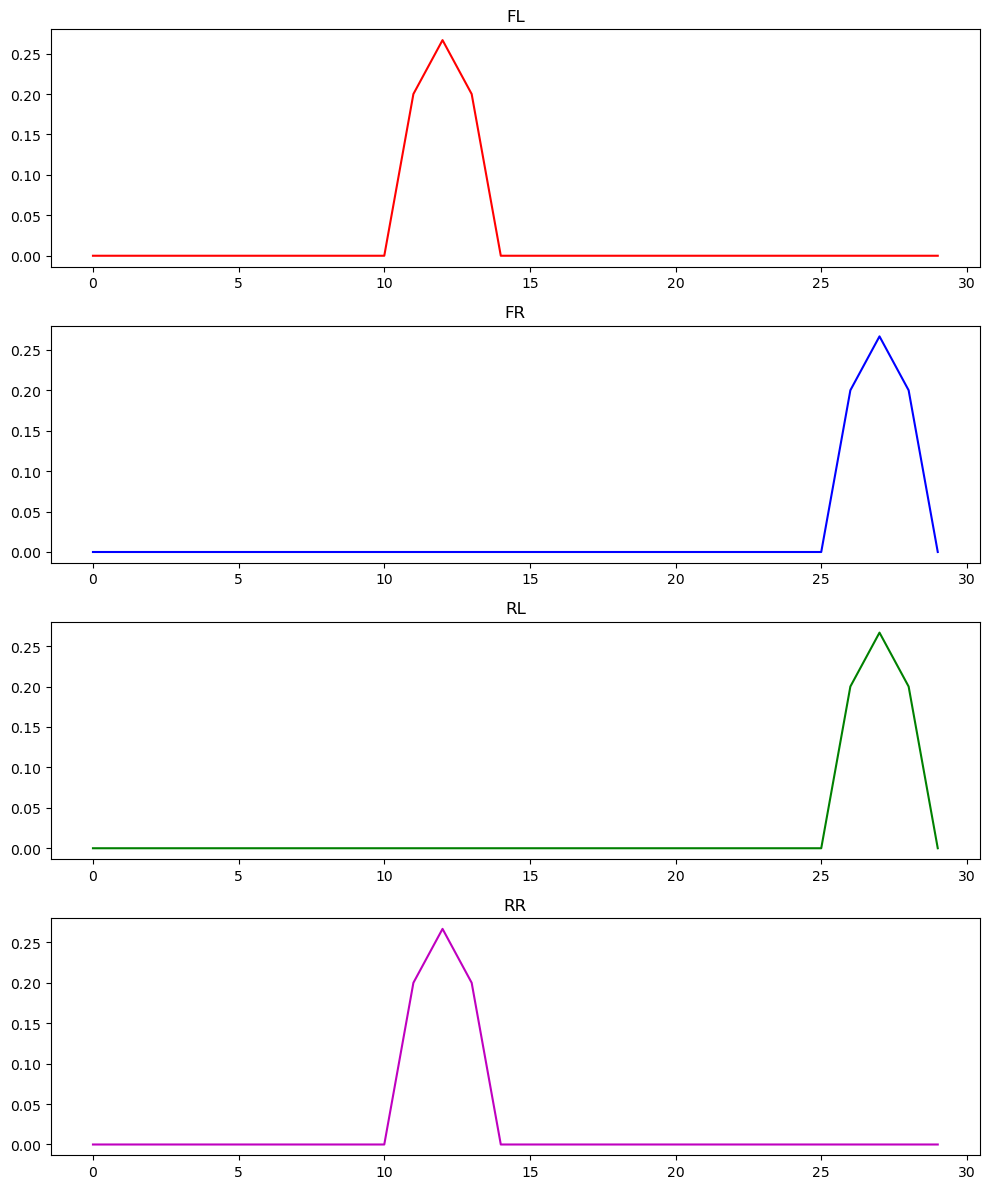

In [86]:
# Creating 4 rows, 1 column of subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 12))

# Plot each row
axs[0].plot(foot_fl_z_ref, 'r-')  # sin(x) in red
axs[0].set_title('FL')

axs[1].plot(foot_fr_z_ref, 'b-')  # cos(x) in blue
axs[1].set_title('FR')

axs[2].plot(foot_rl_z_ref, 'g-')  # tan(x) in green
axs[2].set_title('RL')

axs[3].plot(foot_rr_z_ref, 'm-')  # log(x+1) in magenta
axs[3].set_title('RR')

# Automatically adjust subplot params for better layout
plt.tight_layout()

plt.show()

In [87]:
gait_xyx_offsets = np.stack((foot_fl_x_ref,
                             foot_fl_y_ref,
                             foot_fl_z_ref,
                             foot_fr_x_ref,
                             foot_fr_y_ref,
                             foot_fr_z_ref,
                             foot_rl_x_ref,
                             foot_rl_y_ref,
                             foot_rl_z_ref,
                             foot_rr_x_ref,
                             foot_rr_y_ref,
                             foot_rr_z_ref))

In [88]:
gait_xyx = foot_locs_in[:, np.newaxis] + gait_xyx_offsets

In [89]:
gait_xyx.shape

(12, 30)

In [90]:
gait_xyx[:,0]

array([ 0.1881    ,  0.12675   ,  0.00519415,  0.1881    , -0.12675   ,
        0.00519415, -0.1881    ,  0.12675   ,  0.00519415, -0.1881    ,
       -0.12675   ,  0.00519415])

In [91]:
results = [quad_inverse_kinematics(q_in, gait_xyx[:, i]) for i in range(gait_xyx.shape[1])]
joints_config_gait = np.array(results).T  # Transpose if necessary

In [92]:
joints_config_gait[0,:]

array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.0465, 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    ])

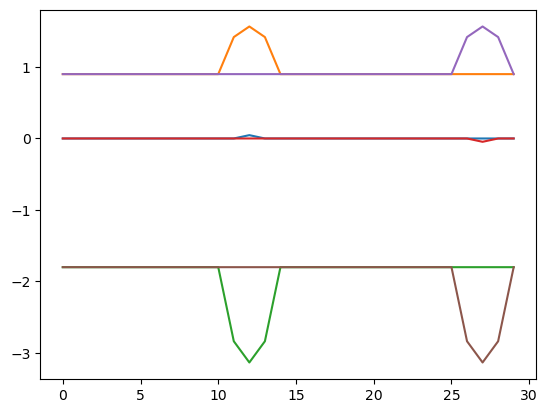

In [93]:
plt.plot(joints_config_gait[0,:])
plt.plot(joints_config_gait[1,:])
plt.plot(joints_config_gait[2,:])
plt.plot(joints_config_gait[3,:])
plt.plot(joints_config_gait[4,:])
plt.plot(joints_config_gait[5,:])

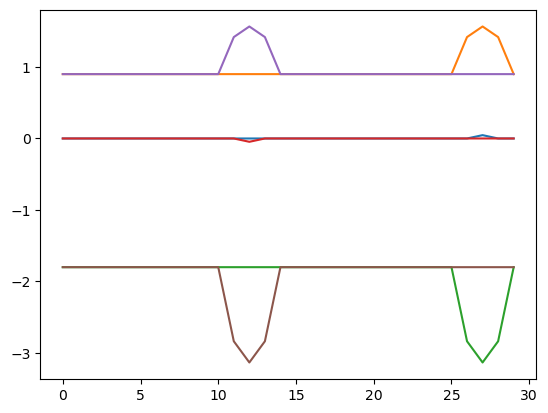

In [94]:
plt.plot(joints_config_gait[6,:])
plt.plot(joints_config_gait[7,:])
plt.plot(joints_config_gait[8,:])
plt.plot(joints_config_gait[9,:])
plt.plot(joints_config_gait[10,:])
plt.plot(joints_config_gait[11,:])

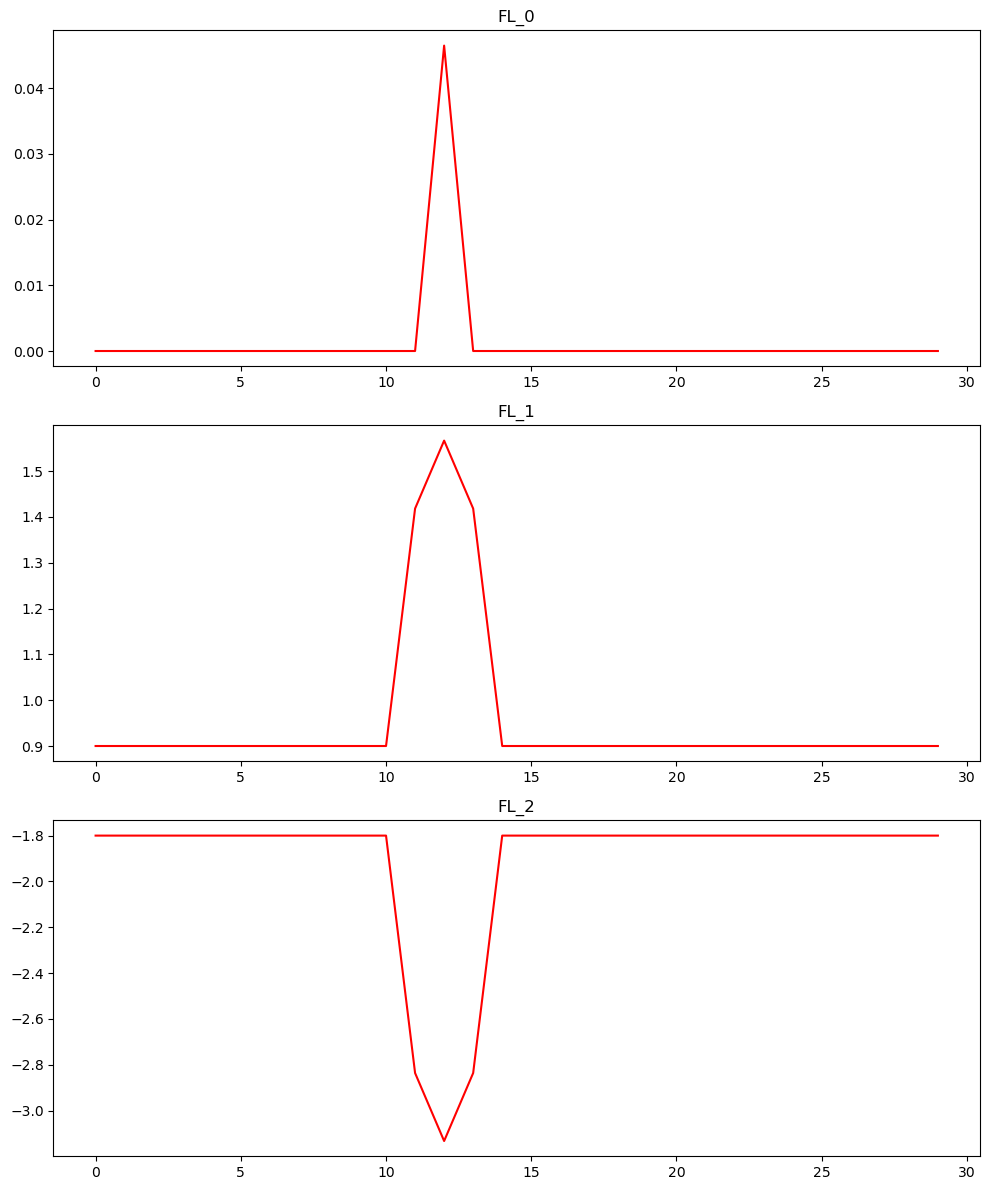

In [95]:
# Creating 4 rows, 1 column of subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# Plot each row
axs[0].plot(joints_config_gait[0,:], 'r-')  # sin(x) in red
axs[0].set_title('FL_0')

# Plot each row
axs[1].plot(joints_config_gait[1,:], 'r-')  # sin(x) in red
axs[1].set_title('FL_1')

# Plot each row
axs[2].plot(joints_config_gait[2,:], 'r-')  # sin(x) in red
axs[2].set_title('FL_2')

# Automatically adjust subplot params for better layout
plt.tight_layout()

plt.show()

In [96]:
joints_config_gait[:,0]

array([ 0. ,  0.9, -1.8, -0. ,  0.9, -1.8,  0. ,  0.9, -1.8, -0. ,  0.9,
       -1.8])

In [97]:
joints_config_gait = joints_config_gait[[3, 4, 5, 0, 1, 2, 9, 10, 11, 6, 7, 8], :]

In [98]:
joints_config_gait.shape

(12, 30)

In [99]:
gait_xyx[:,0]

array([ 0.1881    ,  0.12675   ,  0.00519415,  0.1881    , -0.12675   ,
        0.00519415, -0.1881    ,  0.12675   ,  0.00519415, -0.1881    ,
       -0.12675   ,  0.00519415])

In [100]:
gait_xyx[:,0].shape

(12,)

In [101]:
foot_locs_in

array([ 0.1881    ,  0.12675   ,  0.00519415,  0.1881    , -0.12675   ,
        0.00519415, -0.1881    ,  0.12675   ,  0.00519415, -0.1881    ,
       -0.12675   ,  0.00519415])

In [102]:
# reset robot (keyframes are defined in the xml)
mujoco.mj_resetDataKeyframe(model_sim, data_sim, 0) # stand position
mujoco.mj_forward(model_sim, data_sim)

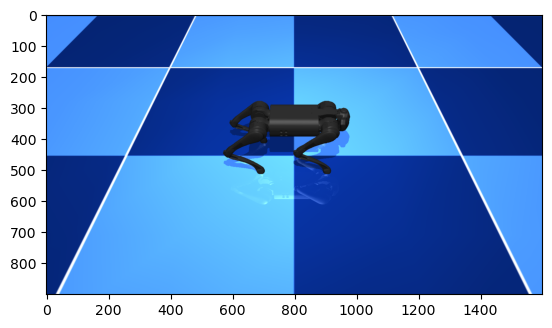

In [103]:
img = viewer.read_pixels()
plt.imshow(img)

In [104]:
%%time
anim_imgs = []
sim_inputs = []
for ticks in range(phase_length()):
    #print(ticks)
    q_curr = cp.deepcopy(data_sim.qpos) # save reference pose
    v_curr = cp.deepcopy(data_sim.qvel) # save reference pose
    u_joints = joints_config_gait[:,ticks]
    data_sim.qpos[7:] = u_joints
    mujoco.mj_forward(model_sim, data_sim)
    img = viewer.read_pixels()
    anim_imgs.append(1*img)

CPU times: user 117 ms, sys: 124 ms, total: 241 ms
Wall time: 252 ms


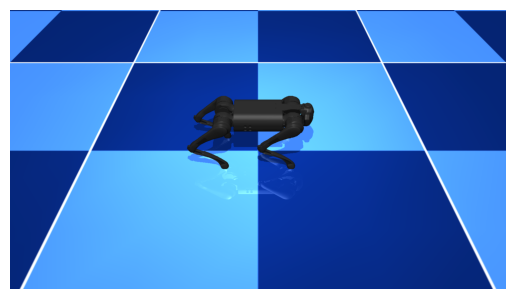

In [105]:
fig, ax = plt.subplots()
skip_frames = 1
interval = dt_sim*1000*skip_frames

def animate(i):
    ax.clear()
    ax.imshow(anim_imgs[i * skip_frames])  # Display the image, skipping frames
    ax.axis('off')

# Create animation, considering the reduced frame rate due to skipped frames
ani = FuncAnimation(fig, animate, frames=len(anim_imgs) // skip_frames, interval=interval)  # 50 ms for 20 Hz

# Display the animation
HTML(ani.to_jshtml())

In [106]:
joints_velocity_gait = np.diff(joints_config_gait, axis=1) / DT

# Since the finite differences reduce the size by 1 along the time axis, you might want to pad it if necessary
# Example padding with zeros
joints_velocity_gait = np.pad(joints_velocity_gait, ((0, 0), (0, 1)), mode='constant')

In [107]:
joints_config_gait.shape

(12, 30)

In [108]:
joints_velocity_gait.shape

(12, 30)

In [109]:
joints_gait = np.vstack((joints_config_gait, joints_velocity_gait))

In [110]:
joints_gait = np.hstack((joints_gait, joints_gait))

In [111]:
joints_gait.shape

(24, 60)

In [112]:
np.savetxt('../gaits/walking_gait_FASTER_HIGHER_25.tsv', joints_gait, delimiter='\t')

In [113]:
walking_gait = np.loadtxt('../gaits/walking_gait_FASTER_HIGHER_25.tsv', delimiter='\t')

In [114]:
walking_gait.shape

(24, 60)

In [66]:
walking_gait[:,0]

array([-0. ,  0.9, -1.8,  0. ,  0.9, -1.8, -0. ,  0.9, -1.8,  0. ,  0.9,
       -1.8,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ])